In [1]:
using RegularizedSystems
using VSTom
using PyPlot
using ProgressMeter

In [2]:
function make_synthetic_data{T<:Real}(A::Array{T,2},dist::Array{T,2},n::T,b::T,dE::T,dP::T)
    y = (dE*dP) * (A*vec(dist))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

In [3]:
wf2 = read_ncdf("/home/lstagner/Dropbox/Inversion_method_analysis/Asger\ source\ code/Transfer_matrix_2_views.nc")
wf3 = read_ncdf("/home/lstagner/Dropbox/Inversion_method_analysis/Asger\ source\ code/Transfer_matrix_3_views.nc")
wf4 = read_ncdf("/home/lstagner/Dropbox/Inversion_method_analysis/Asger\ source\ code/Transfer_matrix_4_views.nc")

Dict{String,Any} with 3 entries:
  "transfer_matrix" => [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0…
  "E"               => [1.0,3.0,5.0,7.0,9.0,11.0,13.0,15.0,17.0,19.0,21.0,23.0,…
  "p"               => [-0.9866666793823242,-0.9599999785423279,-0.933333337306…

In [4]:
nenergy = 20
npitch = 20

test_dists = read_ncdf("data/test_distributions.cdf");
p = vec(test_dists["P"][:,1])
E = vec(test_dists["E"][1,:])
transp_full = test_dists["transp"]


energy_full = wf2["E"]
pitch_full  = wf2["p"]
A_2_full = resize_transfer_matrix(wf2["transfer_matrix"],energy_full,pitch_full,E,p)
A_3_full = resize_transfer_matrix(wf3["transfer_matrix"],energy_full,pitch_full,E,p)
A_4_full = resize_transfer_matrix(wf4["transfer_matrix"],energy_full,pitch_full,E,p)

energy_full = E
pitch_full = p

dE_full = abs(energy_full[2] - energy_full[1])
dP_full = abs(pitch_full[2] - pitch_full[1])

energy = linspace(20.0,maximum(energy_full),nenergy)
pitch = linspace(extrema(pitch_full)...,npitch)
A_2 = resize_transfer_matrix(A_2_full,energy_full,pitch_full,energy,pitch);
A_3 = resize_transfer_matrix(A_3_full,energy_full,pitch_full,energy,pitch);
A_4 = resize_transfer_matrix(A_4_full,energy_full,pitch_full,energy,pitch);

dE = abs(energy[2]-energy[1])
dP = abs(pitch[2]-pitch[1]);
transp = bilinear(transp_full,E,p,energy,pitch);

In [26]:
nr,nc = size(A_2)
x_2 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_2_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TSVDFunctional(A_2,spec,err)
    k = discrete_lcurve(RF,1:120)
    sol = minimize(RF,k)
    x_2[:,i] = max(sol.x,0)/(dE*dP)
end

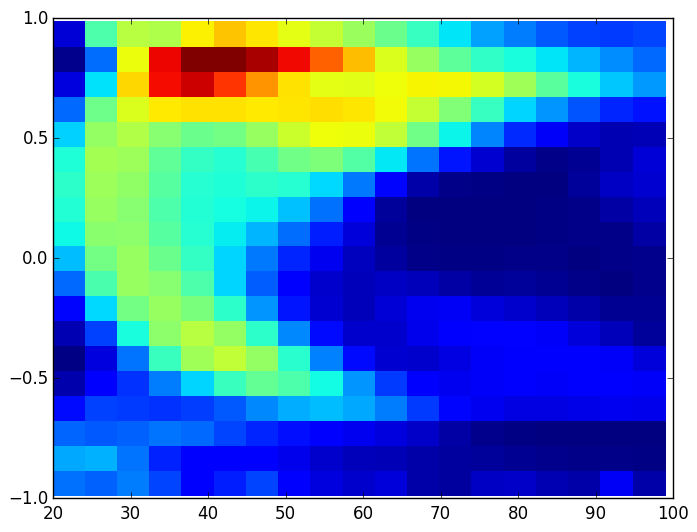

PyObject <matplotlib.collections.PolyCollection object at 0x7fe01a81af28>

In [27]:
pcolor(energy,pitch,reshape(mean(x_2,2),20,20))

In [28]:
nr,nc = size(A_3)
x_3 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_3_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TSVDFunctional(A_3,spec,err)
    k = discrete_lcurve(RF,1:180)
    sol = minimize(RF,k)
    x_3[:,i] = max(sol.x,0)/(dE*dP)
end

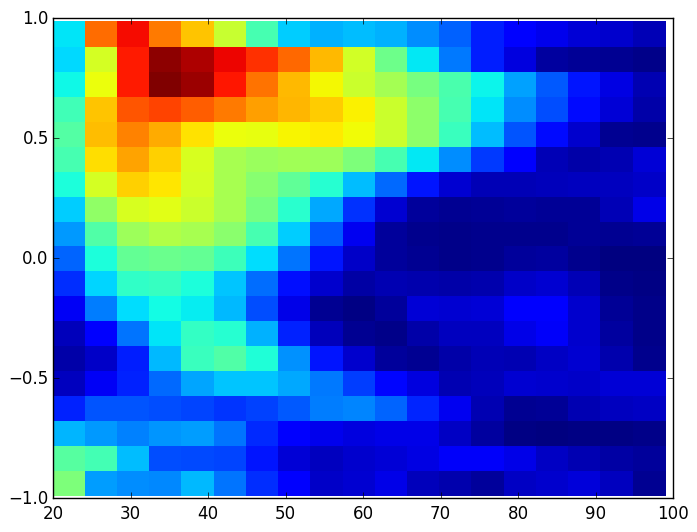

PyObject <matplotlib.collections.PolyCollection object at 0x7fe01a667978>

In [29]:
pcolor(energy,pitch,reshape(mean(x_3,2),20,20))

In [30]:
nr,nc = size(A_4)
x_4 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_4_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TSVDFunctional(A_4,spec,err)
    k = discrete_lcurve(RF,1:180)
    sol = minimize(RF,k)
    x_4[:,i] = max(sol.x,0)/(dE*dP)
end

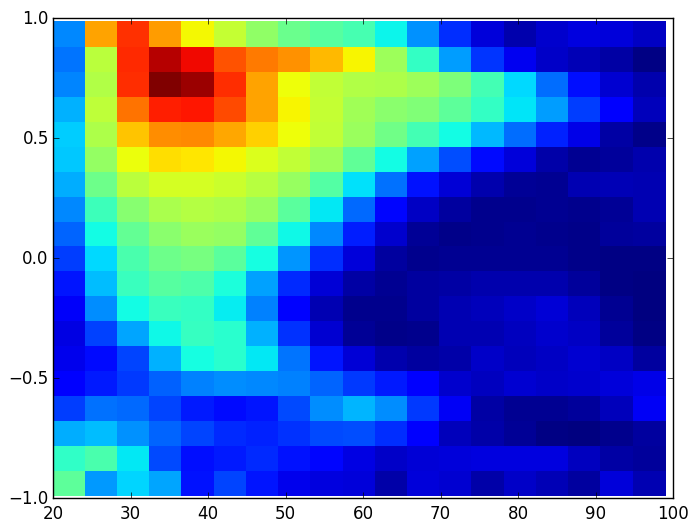

PyObject <matplotlib.collections.PolyCollection object at 0x7fe01a6273c8>

In [31]:
pcolor(energy,pitch,reshape(mean(x_4,2),20,20))

In [33]:
tsvd_x_2_mean = reshape(mean(x_2,2),20,20)
tsvd_x_2_var = reshape(var(x_2,2),20,20)

tsvd_x_3_mean = reshape(mean(x_3,2),20,20)
tsvd_x_3_var = reshape(var(x_3,2),20,20)

tsvd_x_4_mean = reshape(mean(x_4,2),20,20)
tsvd_x_4_var = reshape(var(x_4,2),20,20);

#TIK0

In [34]:
nr,nc = size(A_2)
x_2 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_2_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_2,spec,err,(eye(nc),))
    alpha = lcurve(RF,log_alpha_range=(-10,5),nseeds=20)
    sol = minimize(RF,alpha)
    x_2[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_3)
x_3 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_3_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_3,spec,err,(eye(nc),))
    alpha = lcurve(RF,log_alpha_range=(-10,5),nseeds=20)
    sol = minimize(RF,alpha)
    x_3[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_4)
x_4 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_4_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_4,spec,err,(eye(nc),))
    alpha = lcurve(RF,log_alpha_range=(-10,5),nseeds=20)
    sol = minimize(RF,alpha)
    x_4[:,i] = max(sol.x,0)/(dE*dP)
end

In [39]:
tik0_x_2_mean = reshape(mean(x_2,2),20,20)
tik0_x_2_var = reshape(var(x_2,2),20,20)

tik0_x_3_mean = reshape(mean(x_3,2),20,20)
tik0_x_3_var = reshape(var(x_3,2),20,20)

tik0_x_4_mean = reshape(mean(x_4,2),20,20)
tik0_x_4_var = reshape(var(x_4,2),20,20);

In [40]:
L1E,L1p = gradEP(energy,pitch)

nr,nc = size(A_2)
x_2 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_2_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_2,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20)
    sol = minimize(RF,alpha)
    x_2[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_3)
x_3 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_3_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_3,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20)
    sol = minimize(RF,alpha)
    x_3[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_4)
x_4 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_4_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = TikhonovFunctional(A_4,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20)
    sol = minimize(RF,alpha)
    x_4[:,i] = max(sol.x,0)/(dE*dP)
end

In [45]:
tik1_x_2_mean = reshape(mean(x_2,2),20,20)
tik1_x_2_var = reshape(var(x_2,2),20,20)

tik1_x_3_mean = reshape(mean(x_3,2),20,20)
tik1_x_3_var = reshape(var(x_3,2),20,20)

tik1_x_4_mean = reshape(mean(x_4,2),20,20)
tik1_x_4_var = reshape(var(x_4,2),20,20);

In [46]:
nr,nc = size(A_2)
x_2 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_2_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = FisherFunctional(A_2,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20,kwargs={:maxiter=>5,:verbose=>false})
    sol = minimize(RF,alpha,maxiter=5)
    x_2[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_3)
x_3 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_3_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = FisherFunctional(A_3,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20,kwargs={:maxiter=>5,:verbose=>false})
    sol = minimize(RF,alpha,maxiter=5)
    x_3[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_4)
x_4 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_4_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = FisherFunctional(A_4,spec,err,(L1E,L1p))
    alpha = lcurve(RF,log_alpha_range=(0,20),nseeds=20,kwargs={:maxiter=>5,:verbose=>false})
    sol = minimize(RF,alpha,maxiter=5)
    x_4[:,i] = max(sol.x,0)/(dE*dP)
end

In [47]:
mf_x_2_mean = reshape(mean(x_2,2),20,20)
mf_x_2_var = reshape(var(x_2,2),20,20)

mf_x_3_mean = reshape(mean(x_3,2),20,20)
mf_x_3_var = reshape(var(x_3,2),20,20)

mf_x_4_mean = reshape(mean(x_4,2),20,20)
mf_x_4_var = reshape(var(x_4,2),20,20);

In [49]:
nr,nc = size(A_2)
x_2 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_2_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = EntropyFunctional(A_2,spec,err)
    alpha = lcurve(RF,log_alpha_range=(-15,-5),nseeds=20)
    sol = minimize(RF,alpha)
    x_2[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_3)
x_3 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_3_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = EntropyFunctional(A_3,spec,err)
    alpha = lcurve(RF,log_alpha_range=(-15,-5),nseeds=20)
    sol = minimize(RF,alpha)
    x_3[:,i] = max(sol.x,0)/(dE*dP)
end

nr,nc = size(A_4)
x_4 = zeros(nc,25)
for i=1:25
    spec,err = make_synthetic_data(A_4_full,transp_full,0.5,1.25e14,dE_full,dP_full)
    RF = EntropyFunctional(A_4,spec,err)
    alpha = lcurve(RF,log_alpha_range=(-15,-5),nseeds=20)
    sol = minimize(RF,alpha)
    x_4[:,i] = max(sol.x,0)/(dE*dP)
end

In [50]:
me_x_2_mean = reshape(mean(x_2,2),20,20)
me_x_2_var = reshape(var(x_2,2),20,20)

me_x_3_mean = reshape(mean(x_3,2),20,20)
me_x_3_var = reshape(var(x_3,2),20,20)

me_x_4_mean = reshape(mean(x_4,2),20,20)
me_x_4_var = reshape(var(x_4,2),20,20);

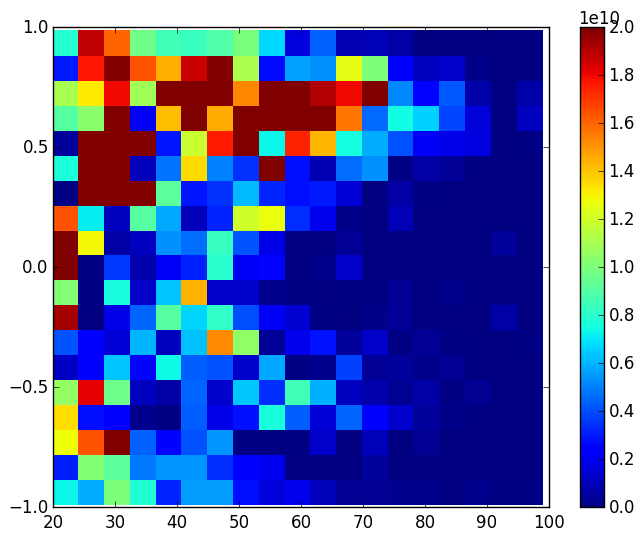

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe019bfa470>

In [58]:
pcolor(energy,pitch,reshape(mean(x_3,2),20,20),vmax=2e10)
colorbar()

In [60]:
using NetCDF
# Write synthetic data to file
fname = "data/view_analysis.cdf"

isfile(fname) && rm(fname)

nen_id = NcDim("nenergy",20)
np_id = NcDim("npitch",20)

tsvd_x_2_mean_varid = NcVar("tsvd_x_2_mean",[np_id,nen_id])
tsvd_x_3_mean_varid = NcVar("tsvd_x_3_mean",[np_id,nen_id])
tsvd_x_4_mean_varid = NcVar("tsvd_x_4_mean",[np_id,nen_id])

tsvd_x_2_var_varid = NcVar("tsvd_x_2_var",[np_id,nen_id])
tsvd_x_3_var_varid = NcVar("tsvd_x_3_var",[np_id,nen_id])
tsvd_x_4_var_varid = NcVar("tsvd_x_4_var",[np_id,nen_id])

tik0_x_2_mean_varid = NcVar("tik0_x_2_mean",[np_id,nen_id])
tik0_x_3_mean_varid = NcVar("tik0_x_3_mean",[np_id,nen_id])
tik0_x_4_mean_varid = NcVar("tik0_x_4_mean",[np_id,nen_id])

tik0_x_2_var_varid = NcVar("tik0_x_2_var",[np_id,nen_id])
tik0_x_3_var_varid = NcVar("tik0_x_3_var",[np_id,nen_id])
tik0_x_4_var_varid = NcVar("tik0_x_4_var",[np_id,nen_id])

tik1_x_2_mean_varid = NcVar("tik1_x_2_mean",[np_id,nen_id])
tik1_x_3_mean_varid = NcVar("tik1_x_3_mean",[np_id,nen_id])
tik1_x_4_mean_varid = NcVar("tik1_x_4_mean",[np_id,nen_id])

tik1_x_2_var_varid = NcVar("tik1_x_2_var",[np_id,nen_id])
tik1_x_3_var_varid = NcVar("tik1_x_3_var",[np_id,nen_id])
tik1_x_4_var_varid = NcVar("tik1_x_4_var",[np_id,nen_id])

mf_x_2_mean_varid = NcVar("mf_x_2_mean",[np_id,nen_id])
mf_x_3_mean_varid = NcVar("mf_x_3_mean",[np_id,nen_id])
mf_x_4_mean_varid = NcVar("mf_x_4_mean",[np_id,nen_id])

mf_x_2_var_varid = NcVar("mf_x_2_var",[np_id,nen_id])
mf_x_3_var_varid = NcVar("mf_x_3_var",[np_id,nen_id])
mf_x_4_var_varid = NcVar("mf_x_4_var",[np_id,nen_id])

me_x_2_mean_varid = NcVar("me_x_2_mean",[np_id,nen_id])
me_x_3_mean_varid = NcVar("me_x_3_mean",[np_id,nen_id])
me_x_4_mean_varid = NcVar("me_x_4_mean",[np_id,nen_id])

me_x_2_var_varid = NcVar("me_x_2_var",[np_id,nen_id])
me_x_3_var_varid = NcVar("me_x_3_var",[np_id,nen_id])
me_x_4_var_varid = NcVar("me_x_4_var",[np_id,nen_id])

energy_varid = NcVar("energy",nen_id)
pitch_varid = NcVar("pitch",np_id)

ncid = NetCDF.create(fname,[tsvd_x_2_mean_varid,tsvd_x_3_mean_varid,tsvd_x_4_mean_varid,
    tsvd_x_2_var_varid,tsvd_x_3_var_varid,tsvd_x_4_var_varid,
    tik0_x_2_mean_varid,tik0_x_3_mean_varid,tik0_x_4_mean_varid,
    tik0_x_2_var_varid,tik0_x_3_var_varid,tik0_x_4_var_varid,
    tik1_x_2_mean_varid,tik1_x_3_mean_varid,tik1_x_4_mean_varid,
    tik1_x_2_var_varid,tik1_x_3_var_varid,tik1_x_4_var_varid,
    mf_x_2_mean_varid,mf_x_3_mean_varid,mf_x_4_mean_varid,
    mf_x_2_var_varid,mf_x_3_var_varid,mf_x_4_var_varid,
    me_x_2_mean_varid,me_x_3_mean_varid,me_x_4_mean_varid,
    me_x_2_var_varid,me_x_3_var_varid,me_x_4_var_varid,energy_varid,pitch_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"tsvd_x_2_mean",tsvd_x_2_mean)
NetCDF.putvar(ncid,"tsvd_x_3_mean",tsvd_x_3_mean)
NetCDF.putvar(ncid,"tsvd_x_4_mean",tsvd_x_4_mean)

NetCDF.putvar(ncid,"tsvd_x_2_var",tsvd_x_2_var)
NetCDF.putvar(ncid,"tsvd_x_3_var",tsvd_x_3_var)
NetCDF.putvar(ncid,"tsvd_x_4_var",tsvd_x_4_var)

NetCDF.putvar(ncid,"tik0_x_2_mean",tik0_x_2_mean)
NetCDF.putvar(ncid,"tik0_x_3_mean",tik0_x_3_mean)
NetCDF.putvar(ncid,"tik0_x_4_mean",tik0_x_4_mean)

NetCDF.putvar(ncid,"tik0_x_2_var",tik0_x_2_var)
NetCDF.putvar(ncid,"tik0_x_3_var",tik0_x_3_var)
NetCDF.putvar(ncid,"tik0_x_4_var",tik0_x_4_var)

NetCDF.putvar(ncid,"tik1_x_2_mean",tik1_x_2_mean)
NetCDF.putvar(ncid,"tik1_x_3_mean",tik1_x_3_mean)
NetCDF.putvar(ncid,"tik1_x_4_mean",tik1_x_4_mean)

NetCDF.putvar(ncid,"tik1_x_2_var",tik1_x_2_var)
NetCDF.putvar(ncid,"tik1_x_3_var",tik1_x_3_var)
NetCDF.putvar(ncid,"tik1_x_4_var",tik1_x_4_var)

NetCDF.putvar(ncid,"mf_x_2_mean",mf_x_2_mean)
NetCDF.putvar(ncid,"mf_x_3_mean",mf_x_3_mean)
NetCDF.putvar(ncid,"mf_x_4_mean",mf_x_4_mean)

NetCDF.putvar(ncid,"mf_x_2_var",mf_x_2_var)
NetCDF.putvar(ncid,"mf_x_3_var",mf_x_3_var)
NetCDF.putvar(ncid,"mf_x_4_var",mf_x_4_var)

NetCDF.putvar(ncid,"me_x_2_mean",me_x_2_mean)
NetCDF.putvar(ncid,"me_x_3_mean",me_x_3_mean)
NetCDF.putvar(ncid,"me_x_4_mean",me_x_4_mean)

NetCDF.putvar(ncid,"me_x_2_var",me_x_2_var)
NetCDF.putvar(ncid,"me_x_3_var",me_x_3_var)
NetCDF.putvar(ncid,"me_x_4_var",me_x_4_var)

NetCDF.putvar(ncid,"energy",energy)
NetCDF.putvar(ncid,"pitch",pitch)

NetCDF.close(ncid);